# Проект: вариант 1

# Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

shared/problem1-reg_data.csv – данные о времени регистрации

shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

Импорт необходимых для исполнения задания библиотек

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy import stats
import plotly.express as px
from scipy.stats import mannwhitneyu
import scipy.stats as ss
from tqdm.auto import tqdm
from scipy.stats import norm
from scipy.stats import levene
from scipy.stats import kstest
from scipy.stats import bootstrap
from  scipy.stats import chi2_contingency

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [82]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.figure(figsize=(15, 5))
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

In [2]:
# Прочитаем данные из файла и сохраним df.
reg_data = pd.read_csv('problem1-reg_data.csv', sep = ';')
auth_data = pd.read_csv('problem1-auth_data.csv', sep = ';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [237]:
reg_data.head(5)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [238]:
auth_data.head(5)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [239]:
# Посмотрим на размер df
reg_data.shape

(1000000, 2)

In [240]:
auth_data.shape

(9601013, 2)

In [241]:
# Уникальное количество пользователей
reg_data.uid.nunique()

1000000

In [242]:
auth_data.uid.nunique()

1000000

In [243]:
# Пустых значений нет
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [244]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [245]:
# Посмотрим на типы данных. 
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [246]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

Каждый uid в df уникальный, поскольку количество строк в df совпадает с количеством уникальных значений uid-ов в df.Соответственно данные не надо чистить от дублей

In [3]:
reg_data.uid.nunique()==reg_data.shape[0]

True

Количество уникальных uid-ов в df меньше, чем количество строк. Говорит о том, что пользователи заходят повторно (и это неплохо, Капитан Очевидность)

In [4]:
auth_data.uid.nunique()==auth_data.shape[0]

False

In [5]:
auth_data.uid.nunique() < auth_data.shape[0]

True

In [6]:
# Объединим df-ы, подходит левое соединение, поэтому не пишу непосредственно как объединять df.
user_activity_data = auth_data.merge(reg_data, on = 'uid')

Проверим, что количество строк в user_activity_data совпадает с количеством строк в auth_data (декартово произведение множеств не получили).

In [7]:
user_activity_data.shape[0] == auth_data.shape[0]

True

In [8]:
# Переведем время из формата UNIX в datetime64, добавив новые колонки. Колонки в формате UNIX оставлю
user_activity_data["date_auth_ts"] =pd.to_datetime(pd.to_datetime(user_activity_data["auth_ts"], unit="s").dt.date)
user_activity_data["date_reg_ts"] = pd.to_datetime(pd.to_datetime(user_activity_data["reg_ts"], unit="s").dt.date)

In [253]:
user_activity_data.dtypes

auth_ts                  int64
uid                      int64
reg_ts                   int64
date_auth_ts    datetime64[ns]
date_reg_ts     datetime64[ns]
dtype: object

In [254]:
user_activity_data.head(3)

,auth_ts,uid,reg_ts,date_auth_ts,date_reg_ts
0,911382223,1,911382223,1998-11-18,1998-11-18
1,932683089,2,932683089,1999-07-22,1999-07-22
2,932921206,2,932683089,1999-07-25,1999-07-22


In [255]:
# Проверим тип данных. Даты имеют корректный тип
user_activity_data.dtypes

auth_ts                  int64
uid                      int64
reg_ts                   int64
date_auth_ts    datetime64[ns]
date_reg_ts     datetime64[ns]
dtype: object

Проверка: есть ли такие пользователи для которых в df указано более одной даты регистрации (по логике не должно)

In [9]:
user_activity_data.groupby(['uid', 'date_reg_ts'], as_index = False) \
                  .agg({'date_reg_ts':'nunique'})\
                  .query('date_reg_ts > 1')

,uid,date_reg_ts


Надо удалить дубли строк, при условии что совпадает пользователь, дата регистрации и дата авторизации. На самом деле дата регистрации здесь излишняя

In [10]:
user_activity_data = user_activity_data.sort_values('date_auth_ts', ascending = False)\
                                       .drop_duplicates(['reg_ts', 'date_auth_ts','date_reg_ts'])

Рассчитываем, сколько существует аккаунт с точностью до дня. Цель: рассчитать retention по пользователям, которые зарегистрировались не более чем 30 дн. от актуальной даты. За актуальную дату принимаем максимальную дату авторизации в df.

In [11]:
user_activity_data['uid_age'] = user_activity_data.date_auth_ts.max() - user_activity_data.date_reg_ts

In [259]:
user_activity_data.head()

,auth_ts,uid,reg_ts,date_auth_ts,date_reg_ts,uid_age
9601012,1600874244,1110622,1600874244,2020-09-23,2020-09-23,0 days
6141651,1600864280,387650,1545574952,2020-09-23,2018-12-23,640 days
2811204,1600863007,118205,1483167131,2020-09-23,2016-12-31,1362 days
4743634,1600862817,253426,1523230103,2020-09-23,2018-04-08,899 days
4744122,1600827437,253446,1523234248,2020-09-23,2018-04-09,898 days


In [12]:
for_retention = user_activity_data.query('uid_age <= "30 days"')

In [13]:
# проверили период
for_retention['date_auth_ts'].agg(['min','max'])

min   2020-08-24
max   2020-09-23
Name: date_auth_ts, dtype: datetime64[ns]

Посчитаем когорты, как разницу между датой авторизации и датой регистрации

In [14]:
for_retention['cohort_distance']= (for_retention.date_auth_ts - for_retention.date_reg_ts)/(np.timedelta64(1, 'D'))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [263]:
for_retention.dtypes

auth_ts                      int64
uid                          int64
reg_ts                       int64
date_auth_ts        datetime64[ns]
date_reg_ts         datetime64[ns]
uid_age            timedelta64[ns]
cohort_distance            float64
dtype: object

In [264]:
for_retention.head(3)

,auth_ts,uid,reg_ts,date_auth_ts,date_reg_ts,uid_age,cohort_distance
9601012,1600874244,1110622,1600874244,2020-09-23,2020-09-23,0 days,0.0
9572509,1600850075,1086154,1599705334,2020-09-23,2020-09-10,13 days,13.0
9565942,1600868217,1081880,1599498246,2020-09-23,2020-09-07,16 days,16.0


In [15]:
for_retention.date_reg_ts= pd.to_datetime(for_retention['date_reg_ts'], format='%Y-%m-%dT')

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [16]:
retention = for_retention.pivot_table(index='date_reg_ts',columns='cohort_distance',values='uid',aggfunc=pd.Series.nunique)
retention

cohort_distance,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
date_reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-08-24,1565.0,28.0,65.0,67.0,80.0,90.0,119.0,94.0,77.0,81.0,...,55.0,57.0,54.0,70.0,49.0,51.0,49.0,49.0,44.0,20.0
2020-08-25,1567.0,31.0,69.0,75.0,89.0,83.0,83.0,98.0,58.0,90.0,...,55.0,56.0,51.0,51.0,69.0,44.0,49.0,50.0,36.0,NaN
2020-08-26,1570.0,23.0,54.0,66.0,71.0,101.0,103.0,94.0,72.0,68.0,...,41.0,67.0,51.0,43.0,46.0,44.0,43.0,26.0,NaN,NaN
2020-08-27,1573.0,26.0,53.0,75.0,82.0,87.0,97.0,90.0,68.0,85.0,...,73.0,47.0,47.0,61.0,53.0,43.0,23.0,NaN,NaN,NaN
2020-08-28,1575.0,32.0,72.0,83.0,75.0,99.0,98.0,86.0,88.0,83.0,...,69.0,74.0,64.0,45.0,58.0,40.0,NaN,NaN,NaN,NaN
2020-08-29,1578.0,40.0,59.0,73.0,90.0,87.0,110.0,90.0,72.0,95.0,...,70.0,67.0,55.0,56.0,27.0,NaN,NaN,NaN,NaN,NaN
2020-08-30,1580.0,29.0,55.0,62.0,85.0,94.0,104.0,88.0,68.0,68.0,...,57.0,64.0,59.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-31,1583.0,29.0,58.0,67.0,81.0,109.0,103.0,106.0,76.0,85.0,...,63.0,44.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,1586.0,32.0,65.0,67.0,73.0,102.0,89.0,102.0,65.0,86.0,...,69.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


На основании рассчитанных данных выведем тепловую карту

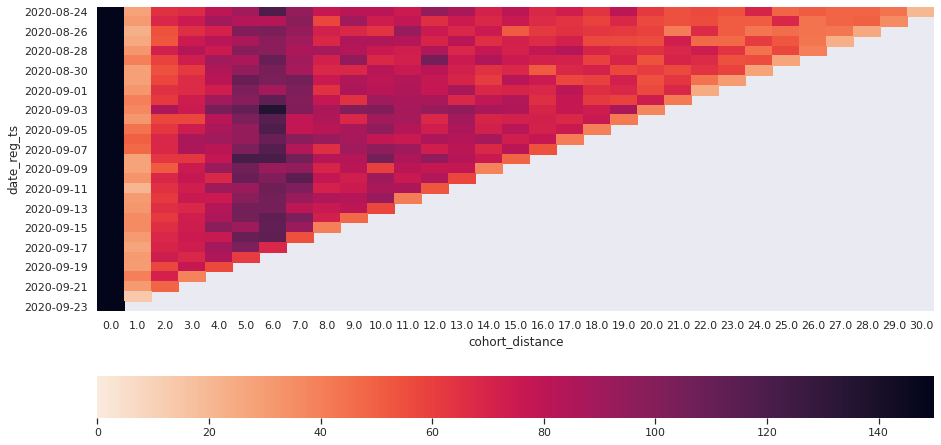

In [21]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(retention, vmin=0, vmax=150, fmt='.1g', cbar_kws= {'orientation': 'horizontal'}, cmap='rocket_r')
ticklabels = [retention.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels);

Преобразуем данные в процентные показатели

In [22]:
cohort_pivot = retention.div(retention[0],axis=0).style.format("{:.2%}", na_rep="")
cohort_pivot

cohort_distance,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
date_reg_ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-24 00:00:00,100.00%,1.79%,4.15%,4.28%,5.11%,5.75%,7.60%,6.01%,4.92%,5.18%,5.18%,4.79%,6.01%,5.56%,4.54%,5.11%,4.35%,4.66%,4.09%,5.11%,3.96%,3.51%,3.64%,3.45%,4.47%,3.13%,3.26%,3.13%,3.13%,2.81%,1.28%
2020-08-25 00:00:00,100.00%,1.98%,4.40%,4.79%,5.68%,5.30%,5.30%,6.25%,3.70%,5.74%,4.72%,5.04%,4.21%,4.79%,4.34%,4.85%,4.28%,4.08%,3.77%,4.34%,3.64%,3.51%,3.57%,3.25%,3.25%,4.40%,2.81%,3.13%,3.19%,2.30%,
2020-08-26 00:00:00,100.00%,1.46%,3.44%,4.20%,4.52%,6.43%,6.56%,5.99%,4.59%,4.33%,4.08%,5.92%,4.78%,4.39%,4.78%,3.31%,3.95%,4.14%,4.01%,3.95%,3.76%,2.61%,4.27%,3.25%,2.74%,2.93%,2.80%,2.74%,1.66%,,
2020-08-27 00:00:00,100.00%,1.65%,3.37%,4.77%,5.21%,5.53%,6.17%,5.72%,4.32%,5.40%,5.40%,5.28%,4.45%,5.15%,4.20%,4.58%,4.26%,4.58%,3.62%,3.62%,3.56%,4.64%,2.99%,2.99%,3.88%,3.37%,2.73%,1.46%,,,
2020-08-28 00:00:00,100.00%,2.03%,4.57%,5.27%,4.76%,6.29%,6.22%,5.46%,5.59%,5.27%,4.83%,4.63%,5.40%,4.38%,4.89%,4.51%,4.95%,5.27%,4.44%,4.25%,4.13%,4.38%,4.70%,4.06%,2.86%,3.68%,2.54%,,,,
2020-08-29 00:00:00,100.00%,2.53%,3.74%,4.63%,5.70%,5.51%,6.97%,5.70%,4.56%,6.02%,4.31%,4.56%,6.65%,4.75%,5.39%,4.75%,4.56%,4.50%,3.80%,4.44%,3.42%,4.44%,4.25%,3.49%,3.55%,1.71%,,,,,
2020-08-30 00:00:00,100.00%,1.84%,3.48%,3.92%,5.38%,5.95%,6.58%,5.57%,4.30%,4.30%,5.19%,4.81%,5.13%,4.56%,4.11%,4.37%,3.29%,4.30%,4.49%,3.67%,3.86%,3.61%,4.05%,3.73%,1.77%,,,,,,
2020-08-31 00:00:00,100.00%,1.83%,3.66%,4.23%,5.12%,6.89%,6.51%,6.70%,4.80%,5.37%,5.05%,5.31%,4.86%,4.42%,3.85%,5.18%,4.74%,3.66%,3.79%,4.55%,3.47%,3.98%,2.78%,1.90%,,,,,,,
2020-09-01 00:00:00,100.00%,2.02%,4.10%,4.22%,4.60%,6.43%,5.61%,6.43%,4.10%,5.42%,5.11%,5.36%,4.85%,5.49%,4.29%,4.41%,4.35%,5.04%,4.16%,4.35%,3.59%,4.35%,1.58%,,,,,,,,


Ниже представлена функция для расчета метрики retention. Результаты расчетов визуализированы в виде таблицы(retention рассчитан в % отношении к количеству зарегистрированных пользователей на дату) и тепловой карты.

In [23]:
def retention (auth_data, reg_data, period):
    """Фунция с помощью которой рассчитывается retention """
      
    # Объединим исходные датафреймы
    user_activity_data = auth_data.merge(reg_data, on = 'uid')
    
    # Проводим даты к удобному виду 
    user_activity_data["date_auth_ts"] =pd.to_datetime(pd.to_datetime(user_activity_data["auth_ts"], unit="s").dt.date)
    user_activity_data["date_reg_ts"] = pd.to_datetime(pd.to_datetime(user_activity_data["reg_ts"], unit="s").dt.date)
    
    # Удаляем дубликаты
    user_activity_data = user_activity_data.sort_values('date_auth_ts', ascending = False).drop_duplicates(['reg_ts', 'date_auth_ts','date_reg_ts'])
    
    # Срок жизни аккаунта
    user_activity_data['uid_age'] = user_activity_data.date_auth_ts.max() - user_activity_data.date_reg_ts
    
    # Удаляем аккаунты, которые зарегистрированы больше дней, чем записано в переменной days
    for_retention = user_activity_data.query('uid_age <= @period')
    
    # Посчитаем когорты, как разницу между датой авторизации и датой регистрации
    for_retention['cohort_distance']= (for_retention.date_auth_ts - for_retention.date_reg_ts)/(np.timedelta64(1, 'D'))
    
    # Преобразуем df в сводную таблицу
    retention = for_retention.pivot_table(index='date_reg_ts',columns='cohort_distance',values='uid',aggfunc=pd.Series.nunique)
    
    # Преобразуем данные в процентные показатели
    cohort_pivot = retention.div(retention[0],axis=0).style.format("{:.2%}", na_rep="")
    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.heatmap(retention, vmin=0, vmax=150, fmt='.1g', cbar_kws= {'orientation': 'horizontal'},cmap='rocket_r')
    ticklabels = [retention.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
    ax.set_yticklabels(ticklabels);
    
    return cohort_pivot


Запустили функцию

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cohort_distance,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
date_reg_ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-24 00:00:00,100.00%,1.79%,4.15%,4.28%,5.11%,5.75%,7.60%,6.01%,4.92%,5.18%,5.18%,4.79%,6.01%,5.56%,4.54%,5.11%,4.35%,4.66%,4.09%,5.11%,3.96%,3.51%,3.64%,3.45%,4.47%,3.13%,3.26%,3.13%,3.13%,2.81%,1.28%
2020-08-25 00:00:00,100.00%,1.98%,4.40%,4.79%,5.68%,5.30%,5.30%,6.25%,3.70%,5.74%,4.72%,5.04%,4.21%,4.79%,4.34%,4.85%,4.28%,4.08%,3.77%,4.34%,3.64%,3.51%,3.57%,3.25%,3.25%,4.40%,2.81%,3.13%,3.19%,2.30%,
2020-08-26 00:00:00,100.00%,1.46%,3.44%,4.20%,4.52%,6.43%,6.56%,5.99%,4.59%,4.33%,4.08%,5.92%,4.78%,4.39%,4.78%,3.31%,3.95%,4.14%,4.01%,3.95%,3.76%,2.61%,4.27%,3.25%,2.74%,2.93%,2.80%,2.74%,1.66%,,
2020-08-27 00:00:00,100.00%,1.65%,3.37%,4.77%,5.21%,5.53%,6.17%,5.72%,4.32%,5.40%,5.40%,5.28%,4.45%,5.15%,4.20%,4.58%,4.26%,4.58%,3.62%,3.62%,3.56%,4.64%,2.99%,2.99%,3.88%,3.37%,2.73%,1.46%,,,
2020-08-28 00:00:00,100.00%,2.03%,4.57%,5.27%,4.76%,6.29%,6.22%,5.46%,5.59%,5.27%,4.83%,4.63%,5.40%,4.38%,4.89%,4.51%,4.95%,5.27%,4.44%,4.25%,4.13%,4.38%,4.70%,4.06%,2.86%,3.68%,2.54%,,,,
2020-08-29 00:00:00,100.00%,2.53%,3.74%,4.63%,5.70%,5.51%,6.97%,5.70%,4.56%,6.02%,4.31%,4.56%,6.65%,4.75%,5.39%,4.75%,4.56%,4.50%,3.80%,4.44%,3.42%,4.44%,4.25%,3.49%,3.55%,1.71%,,,,,
2020-08-30 00:00:00,100.00%,1.84%,3.48%,3.92%,5.38%,5.95%,6.58%,5.57%,4.30%,4.30%,5.19%,4.81%,5.13%,4.56%,4.11%,4.37%,3.29%,4.30%,4.49%,3.67%,3.86%,3.61%,4.05%,3.73%,1.77%,,,,,,
2020-08-31 00:00:00,100.00%,1.83%,3.66%,4.23%,5.12%,6.89%,6.51%,6.70%,4.80%,5.37%,5.05%,5.31%,4.86%,4.42%,3.85%,5.18%,4.74%,3.66%,3.79%,4.55%,3.47%,3.98%,2.78%,1.90%,,,,,,,
2020-09-01 00:00:00,100.00%,2.02%,4.10%,4.22%,4.60%,6.43%,5.61%,6.43%,4.10%,5.42%,5.11%,5.36%,4.85%,5.49%,4.29%,4.41%,4.35%,5.04%,4.16%,4.35%,3.59%,4.35%,1.58%,,,,,,,,


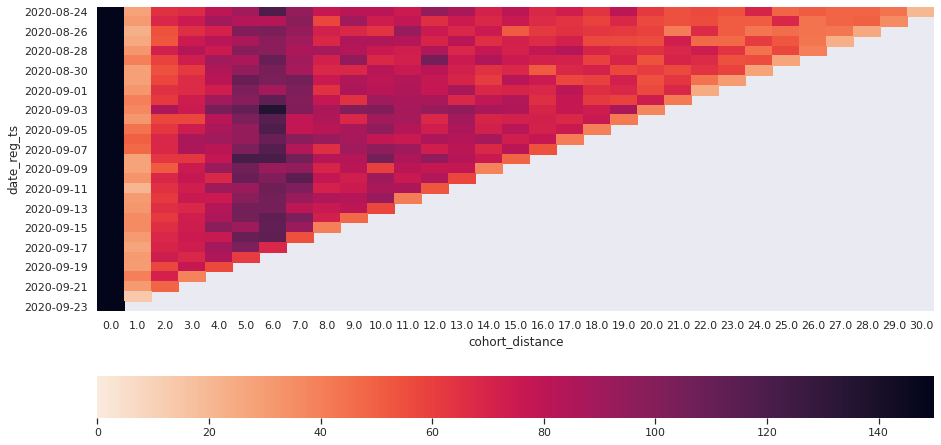

In [24]:
retention(auth_data, reg_data, period=datetime.timedelta(days=30))

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [35]:
data = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')

In [4]:
data.head(3)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a


Проверим основные показатели датасета. 

In [10]:
data.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [11]:
data.shape

(404770, 3)

In [12]:
# кол-во уникальных id равно кол-ву строк в df.
data.user_id.nunique()

404770

In [13]:
data.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Для оценки результатов проводимого эксперимента будем использовать следующие метрики:

    1) APRU - средний доход с пользователя;
    2) ARPPU - средний доход с платящих пользователей;
    3) Conversion rate (CR) - соотношения платящих пользователей к общему числу пользователей.

In [3]:
#APRU
apru = data.groupby('testgroup', as_index=False)\
    .agg({'revenue': 'mean', 'user_id': 'count'})\
    .rename(columns={'revenue': 'apru', 'user_id': 'users_count_apru'}).round(2)
apru

,testgroup,apru,users_count_apru
0,a,25.41,202103
1,b,26.75,202667


In [4]:
#ARPPU
arppu = data.query('revenue > 0')\
    .groupby('testgroup', as_index=False)\
    .agg({'revenue': 'mean', 'user_id': 'count'})\
    .rename(columns={'revenue': 'arppu', 'user_id': 'users_count_arppu'}).round(2)
arppu

,testgroup,arppu,users_count_arppu
0,a,2664.00,1928
1,b,3003.66,1805


In [43]:
#CR
cr_data = data.query('revenue > 0').groupby('testgroup', as_index=False)['user_id'].count()
cr_data['unpaying_users'] = data.query('revenue  == 0').groupby('testgroup', as_index=False)['user_id'].count().user_id
cr_data['all_users'] = data.groupby('testgroup', as_index=False)['user_id'].count().user_id
cr_data['cr'] = cr_data['user_id'] / cr_data['all_users']
cr_data

,testgroup,user_id,unpaying_users,all_users,cr
0,a,1928,200175,202103,0.009540
1,b,1805,200862,202667,0.008906


Объединим ключевые метрики в один df и рассмотрим подробнее результаты.
    1) APRU в тестовой группе выше, как и было указано в условиях задачи;
    2) ARPPU также в тестовой группе выше;
    3) CR выше в контрольной группе

In [17]:
data_stat = apru.merge(arppu, how='inner', on='testgroup')
data_stat = data_stat.merge(cr_data, how='inner', on='testgroup')
data_stat = data_stat[['testgroup', 'apru', 'arppu', 'cr', 'users_count_apru', 'users_count_arppu']]
data_stat

,testgroup,apru,arppu,cr,users_count_apru,users_count_arppu
0,a,25.41,2664.00,0.009540,202103,1928
1,b,26.75,3003.66,0.008906,202667,1805


Посмотрим на изменение ключевых метрик в тестовой группе по отношению к контрольной. Добавим строчку в DF data_stat.

In [9]:
proportion_apru = ((data_stat.apru[1]*100)/data_stat.apru[0]).round(2)

In [10]:
proportion_arppu = ((data_stat.arppu[1]*100)/data_stat.arppu[0]).round(2)

In [11]:
proportion_cr =((data_stat.cr[1]*100)/data_stat.cr[0]).round(2)

In [12]:
new_row = {'testgroup':'proportion_b/a', 'apru': proportion_apru, 'arppu': proportion_arppu, 'cr': proportion_cr}

In [13]:
data_stat = data_stat.append(new_row, ignore_index=True)
data_stat

,testgroup,apru,arppu,cr,users_count_apru,users_count_arppu
0,a,25.41,2664.00,0.009540,202103.0,1928.0
1,b,26.75,3003.66,0.008906,202667.0,1805.0
2,proportion_b/a,105.27,112.75,93.360000,NaN,NaN


APRU - средний доход с пользователя в тестовой группе увеличился на 5% по сравнению с контрольной.
ARPPU - средний доход с платящих пользователей в тестовой группе увеличился почти на 13% по сравнению с контрольной.
CR - соотношения платящих пользователей к общему числу пользователей в тестовой группе уменьшился почти на 7% (6.64%, ниже вернемся к этому значению) по сравнению с контрольной.

Для выявления причин возникновения таких различий в метриках, рассмотрим поближе данные revenue в предложенном датасете.

**Сравним являются ли различия APRU в тестовой и контрольной группах статистически значимыми**

Посмотрим на данные по всем пользователям, вне зависимости от величины revenue

In [14]:
# Выбрала в отдельный датасет данные с группой "a"
a = data.query('testgroup == "a"')
a.head(3)

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a


In [15]:
# пользователи в группе а - контрольная группа, поскольку кол-во записей соответствует условиям в задаче
a.shape

(202103, 3)

In [16]:
a.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [17]:
# Выбрала в отдельный датасет данные с группой "b"
b = data.query('testgroup == "b"')
b.head(3)

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b


In [18]:
# пользователи в группе b - тестовая группа, поскольку кол-во записей соответствует условиям в задаче
b.shape

(202667, 3)

In [19]:
b.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


.describe() показывает, величину дисперсии выборок, а также показывает что в выборках распределение отлично от нормального (смотрим на значения перцентилей). 

Проверим являются ли дисперсии в генеральных совокупностях гомогенны. Для это используем метод Левена.
H0: дисперсии гомогенны
H1: дисперсии не являются гомогенными

pval Levene = 0.532495, следовательно дисперсии гомогенны. Принимаем 0 гипотезу.

In [20]:
pg.homoscedasticity(data=data, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


Проверим нормальность распределения признака в группах. Критерий Шапиро-Уилка используется для проверки гипотезы H0: распределение revenue нормальное.
Ограничения использовани данного критерия - лучше работает с небольшими выборками. В нашем случае выборка относительно большая, постарались нивилировать риски, используя .sample(1000, random_state=17)
Значение pvalue < 0.05, соответственно, мы отвергаем H0 о нормальности распределения.

In [21]:
a_shapiro = data[data['testgroup'] == 'a']['revenue'].sample(1000, random_state=17)
stats.shapiro(a_shapiro)

ShapiroResult(statistic=0.06614720821380615, pvalue=0.0)

In [22]:
b_shapiro = data[data['testgroup'] == 'b']['revenue'].sample(1000, random_state=17)
stats.shapiro(b_shapiro)

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)

Посмотрим на распределение revenue в группе "a" и группе "b". Графики показывают, что в контрольной группе есть значительные выбросы: пользователи доходность по которым превышает 35000 у.е. В контрольной группе заказов с такой доходностью нет.

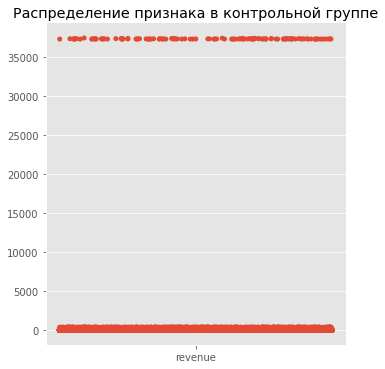

In [84]:
plt.rcParams['figure.figsize'] = (16, 10)
sns.catplot(data = a[['revenue']])
plt.title('Распределение признака в контрольной группе');

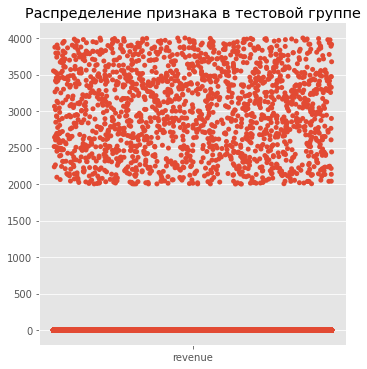

In [85]:
plt.rcParams['figure.figsize'] = (16, 10)
sns.catplot(data = b[['revenue']])
plt.title('Распределение признака в тестовой группе');

**Сравним медианные и средние значения в контрольной и тестовой группах**

Поскольку в контрольной группе имеются выбросы для  ответа на вопрос являются ли различия между группами статистически значимыми воспользуемся бутстрапом. 
Гипотезы:

𝐻0  - различий между средними (медианными) значениями контрольной и тестовой группы нет.
𝐻1  - различия между средними (медианными) значениями контрольной и тестовой группы являются статистически значемы.

In [86]:
a_boot = data.query('testgroup == "a"').revenue
b_boot = data.query('testgroup == "b"').revenue

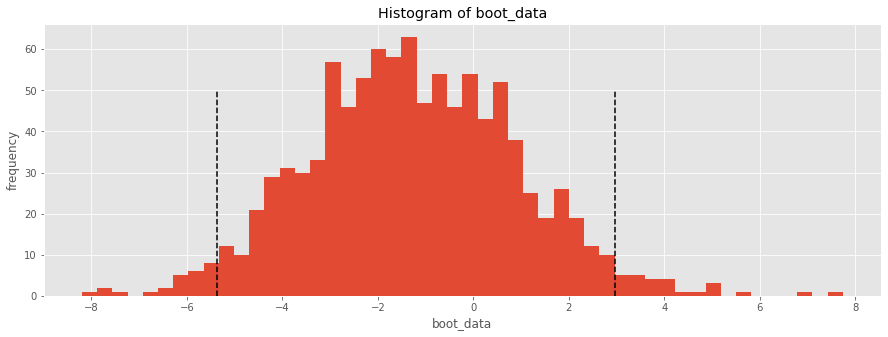

In [87]:
#средние значения
bootstrap_mean = get_bootstrap(
    a_boot, # числовые значения первой выборки
    b_boot, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [88]:
# p-value > 0.05, что не позволяет отклонить нулевую гипотезу о равенстве средних ARPU.
bootstrap_mean['p_value']

0.5649875925236301

In [89]:
# доверительный интервал
bootstrap_mean['ci']

,0
0.025,-5.361832
0.975,2.970078


p-value > 0.05, что не позволяет отклонить нулевую гипотезу о равенстве средних ARPU.

**Сравним являются ли различия ARPPU в тестовой и контрольной группах статистически значимыми**

Посмотрим на данные по пользователям производящим оплаты

Сделаем 2 датасета, в которых выберем только платящих пользователей

In [27]:
a_paying = a.query('revenue != 0')
a_paying.head(3)

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a


In [28]:
b_paying = b.query('revenue != 0')
b_paying.head(3)

,user_id,revenue,testgroup
160,161,3797,b
377,378,3768,b
386,387,3527,b


Посмотрим на статистику данных датасетов.

In [29]:
a_paying.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [30]:
b_paying.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


Посмотрим на распределение revenue в группе "a" и группе "b" среди платящих пользователей. 

График контрольной группы показывает, что большинство пользователей делают покупки создающим небольшим доходом и небольшой (какой?) процент пользователей делают покупки с большим доходом

График тестовой группы показывает, что пользователи создающие доход от 2000 от 4000 единиц распределены достаточно равномерно.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


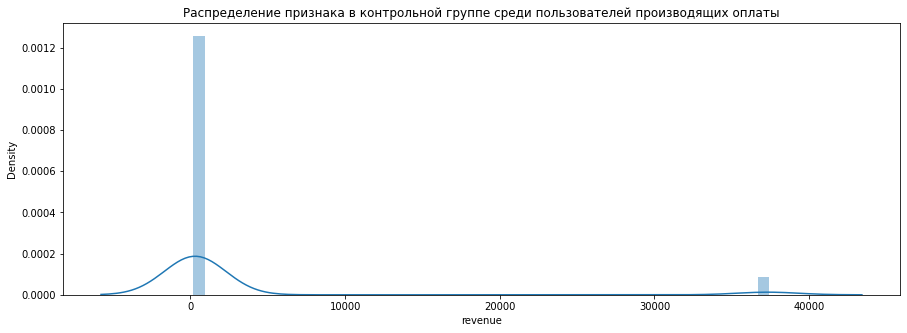

In [32]:
#График распределения revenue выглядит лучше, из него следует, что много пользователей генерящими небольшой доход.
# И есть небольшое количество пользователей дающих больщой доход
plt.figure(figsize=(15, 5))
sns.distplot(a_paying.revenue)
plt.title('Распределение признака в контрольной группе среди пользователей производящих оплаты');

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


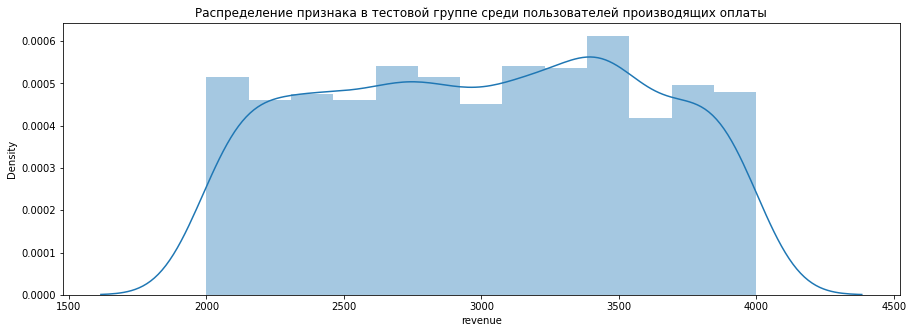

In [33]:
# Примерно одинаковое количество пользователей генерящих доход от 2000 до 4000 единиц.
plt.figure(figsize=(15, 5))
sns.distplot(b_paying.revenue)
plt.title('Распределение признака в тестовой группе среди пользователей производящих оплаты');

Проверим являются ли дисперсии в генеральных совокупностях гомогенны. Для это используем метод Левена. H0: дисперсии гомогенны H1: дисперсии не являются гомогенными 

pval Levene = 3.779690e-19, следовательно дисперсии негомогенны. Отвергаем 0 гипотезу о равенстве дисперсий.

In [72]:
pg.homoscedasticity(data=data.query('revenue >0'), dv="revenue", group="testgroup")

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


Проверим нормальность распределения признака в группах. Критерий Шапиро-Уилка используется для проверки гипотезы H0: распределение revenue нормальное. Ограничения использовани данного критерия - лучше работает с небольшими выборками. В нашем случае выборка относительно большая, постарались нивилировать риски, используя .sample(1000, random_state=17) Значение pvalue < 0.05, соответственно, мы отвергаем H0 о нормальности распределения.


In [73]:
a_paying_shapiro = a_paying['revenue'].sample(1000, random_state=17)
stats.shapiro(a_paying_shapiro)

ShapiroResult(statistic=0.26476240158081055, pvalue=0.0)

In [74]:
b_paying_shapiro = b_paying['revenue'].sample(1000, random_state=17)
stats.shapiro(b_paying_shapiro)

ShapiroResult(statistic=0.9613320827484131, pvalue=1.2885095898576755e-15)

Посмотрим, какое количество пользователей в контрольной группе делают оплаты менее 30000 и какую сумму дохода они формируют.
А также какое количество пользователей в контрольной группе делают оплаты более или равно 30000 и какую сумму дохода они формируют.

In [34]:
# Количество пользователей заказы которых генерят доходы более 30 000 у.е равно 123. 
# Общая сумма дохода, который они формирует составляет 4 590 252
a_paying.query('revenue > 30000').agg({'revenue':'sum', 'user_id':'count'})

revenue    4590252
user_id        123
dtype: int64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


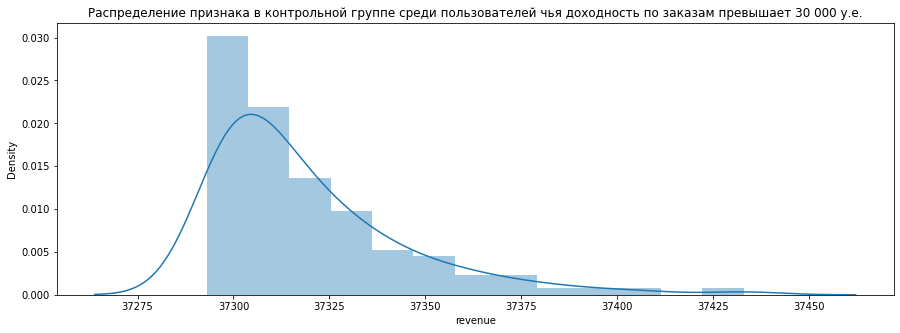

In [35]:
# Посмотрим на распределение revenue среди пользователей, которые генерят заказы с доходностью >30 000 y.e.
plt.figure(figsize=(15, 5))
sns.distplot(a_paying.query('revenue > 30000').revenue)
plt.title('Распределение признака в контрольной группе среди пользователей чья доходность по заказам превышает 30 000 у.е.');

In [36]:
# Количество пользователей заказы которых генерят доходы меньше либо равно 30 000 у.е равно 1805. 
# Общая сумма дохода, который они формирует составляет 545 937
a_paying.query('revenue <= 30000').agg({'revenue':'sum', 'user_id':'count'})

revenue    545937
user_id      1805
dtype: int64

In [37]:
# В процентном выражении пользователи, которые формируют заказы доходностью более 30 000 у.е. создают 89.37% дохода
((a_paying.query('revenue > 30000').agg({'revenue':'sum'})/a_paying.revenue.sum())*100).round(2)

revenue    89.37
dtype: float64

In [38]:
# В процентном выражении пользователи, которые формируют заказы доходностью менее или равно 30 000 у.е.создают 10.63% дохода
((a_paying.query('revenue <= 30000').agg({'revenue':'sum'})/a_paying.revenue.sum())*100).round(2)

revenue    10.63
dtype: float64

In [39]:
# 6,38% пользователей создают  89.37% выручки
((a_paying.query('revenue > 30000').agg({'user_id':'count'})/a_paying.user_id.count())*100).round(2)

user_id    6.38
dtype: float64

In [40]:
# 93.62% пользователей создают  10.63% выручки
((a_paying.query('revenue <= 30000').agg({'user_id':'count'})/a_paying.user_id.count())*100).round(2)

user_id    93.62
dtype: float64

**!!!*** При расчете CR и отношение CR в тестовой группе к CR в контрольной группе было выявлено, что соотношение платящих пользователей уменьшилось на 6.64%. В свою очередь мы видим, что в контрольной группе 6,38% пользователей генерят 89.37% выручки. И именно этот % пользователей в контрольной группе попадает под выбросы. Нельзя просто так отмести этих клиентов, поскольку изменения внесенные в тестовой группе в акционные предложения срезали продажи с высокой доходностью. Надо больше информации по этим клиентам, возможно стоит провести сегментацию клиентов. И проводить статистические тесты в разрезе сегментов.

Несмотря на то, что в тестовой группе нет заказов с высокой доходностью, общая сумма дохода в тестовой группе превышает общий доход в контрольной на 285 414 у.е. 

In [41]:
delta = b_paying.revenue.sum() - a_paying.revenue.sum()
delta

285414

**Сравним медианные и средние значения в контрольной и тестовой группах**

Поскольку в контрольной группе имеются выбросы для  ответа на вопрос являются ли различия между группами статистически значемыми воспользуемся бутстрапом. 
Гипотезы:

𝐻0  - различий между средними (медианными) значениями контрольной и тестовой группы нет.
𝐻1  - различия между средними (медианными) значениями контрольной и тестовой группы являются статистически значемы.

In [75]:
a_paying_boot = data.query('testgroup == "a" and revenue > 0').revenue
b_paying_boot = data.query('testgroup == "b"and revenue > 0').revenue

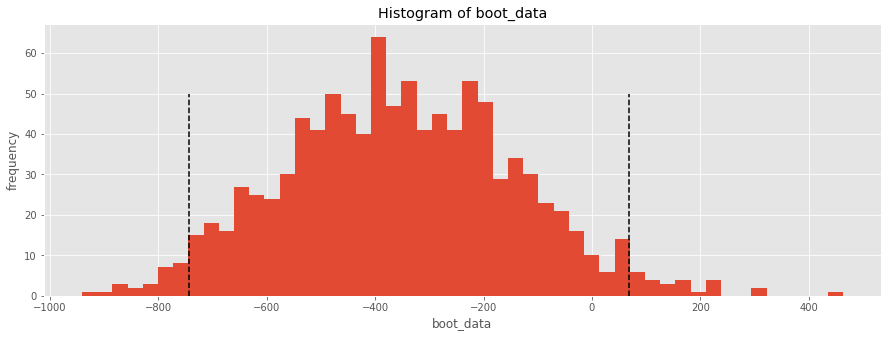

In [76]:
#средние значения
bootstrap_mean_paying = get_bootstrap(
    a_paying_boot, # числовые значения первой выборки
    b_paying_boot, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

p-value > 0.05, что не позволяет отбросить нулевую гипотезу о равенстве средних ARPPU. Но ранее в контрольной группе были выявлены выбросы. В связи с чем сделаем проверку медианных значений. 

In [78]:
bootstrap_mean_paying['p_value']

0.09817160358120945

In [79]:
# доверительный интервал
bootstrap_mean_paying['ci']

,0
0.025,-744.441779
0.975,68.940547


In [ ]:
p-value > 0.05, что не позволяет отклонить нулевую гипотезу о равенстве средних ARPU.

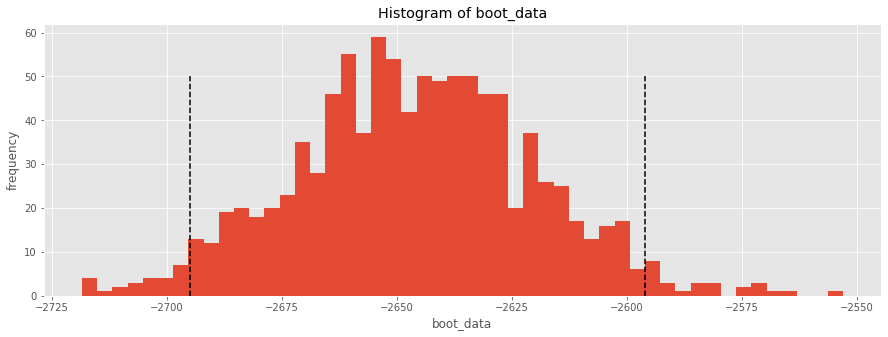

In [77]:
#медианные значения
bootstrap_median_paying = get_bootstrap(
    a_paying_boot, # числовые значения первой выборки
    b_paying_boot, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

 p-value < 0.05, отклоняем H0 о равенстве медианных ARPPU. Предполагаем, что контрольная группа статистически значимо отличается от тестовой.

In [80]:
bootstrap_median_paying['p_value']

0.0

In [81]:
# доверительный интервал
bootstrap_median_paying['ci']

,0
0.025,-2695.0250
0.975,-2595.9875


 p-value < 0.05, что позволяет отбросить нулевую гипотезу о равенстве медианных ARPPU.

**ИТОГИ по ARPPU:**
Cравнение группы 'a' (с выбросами) и тестовой группы 'b': результаты бустрапа с оценкой среднего с выборочными данными контрольной группы не позволяют нам отклонить нулевую гипотезу о равенстве средних, поскольку pvalue > 0.05. 

Cравнение группы 'a' (с выбросами) и тестовой группы 'b'. Результаты бустрапа с оценкой медианного с выборочными данными контрольной группы позволяют нам отклонить нулевую гипотезу о равенстве средних, поскольку pvalue < 0.05. Вероятно выявлены статистически значимые различия между выборками.

Вероятно, эксперимент, проводимый с выборкой 'b' привнес положительный эффект на переход пользователя в группу платящих пользователей.

**Сравним являются ли различия CR в тестовой и контрольной группах статистически значимыми**

Для оценки различий воспользуемся критерием хи-квадрат.
H0: различия не являются статистически значимыми, соответственно, CR в группах различается несущественно;
H1: различия являются статистически значимыми, соответственно, CR в группах статистически значимо отличается.

In [48]:
data.head(3)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a


Подготовим DF для проверки гипотез критерием хи-квадрат.

In [49]:
chisqt = data
chisqt['pay'] = chisqt.revenue.apply(lambda x: 'no' if x ==0  else 'yes')

In [52]:
chisqt.query('revenue >0')

,user_id,revenue,testgroup,pay
72,73,351,a,yes
160,161,3797,b,yes
341,342,290,a,yes
377,378,3768,b,yes
385,386,250,a,yes
...,...,...,...,...
404315,404316,262,a,yes
404525,404526,3120,b,yes
404543,404544,369,a,yes
404602,404603,251,a,yes


In [54]:
chisqt_cross = pd.crosstab(chisqt['pay'], chisqt['testgroup'])
chisqt_cross

testgroup,a,b
pay,,
no,200175,200862
yes,1928,1805


In [57]:
kf = chi2_contingency(chisqt_cross)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)

chisq-statistic=4.3747, p-value=0.0365, df=1 expected_frep=[[200239.10075104 200797.89924896]
 [  1863.89924896   1869.10075104]]


p-value=0.0365. Поскольку p-val < 0.05 мы не можем принять гипотезу о статистически незначимых различиях. В тестовой группе CR статистически значимо ниже, чем в контрольной группе, т.е. эксперемент отрицательно повлиял на переход пользователя в группу платящих.

**ИТОГИ** 
Подводя итог можно сказать, что благодаря проводимому эксперименту увеличились продажи с невысокой доходностью, что в целом очень неплохой результат. Но стоит отметить, что в контрольной группе были заказы с высокой доходностью и они давали значимый объем продаж. В тестовой группе заказов с высокой доходностью нет. 
Предполагаю, что надо временно отменить проведение эксперимента (не раскатывать его на всю аудиторию) и разобрать кейсы с пользователями с высокой доходностью. Возможно, стоит ввести сегментацию пользователей и раскатывать эксперименты по сегментам с целью вывести средний чек на более высокий уровень, при этом не зарезав продажи с высоким чеком.

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Метрики для обоих вариантов проведения тематических событий:
1. Воронка прохождения уровней. Воронка покажет конверсию между шагами (отношение пользователей на шаге N к пользователям на шаге N-1), позволяет выявить узкие места мероприятий, где эта конверсия падает сильнее, чем на других шагах, то есть в каком месте происходит самый большой отток пользователей;
2. Retention. Посмотреть в динамике, возможно проведением события мы повлияем на активность пользователей в последующие периода (пичем повлиять можем как в большую сторону, так и в меньшую);
3. DAU - число уникальных пользователей в день. Сравним в динамике. Возможно, наше событие привлечет аудиторию, если мы не забудем их уведомить о мероприятии (пуши, сообщение и т.д.);
4. WAU  - аналогично с предыдущей метрикой, можно проанализировать изменится ли показатель после проведения мероприятий;
5. Users online(CCU Concurrent users) - количество активных пользователей.И PCCU (Peak Concurrent Users) – максимальное 
количество пользователей, одновременно находящихся в приложении. Пользователей можно просегмениторовать на тех, кто участвует в мероприятии и нет, возможно прирост нецелевой (пользователи не участвуют в мероприятии).Если мероприятие краткосрочное и проводится одновременно для всех пользователей и наше приложении пользуется спросом во всем мире. Следует учесть часовые пояса в сегментации (Япония и центр.часть РФ активность пользователей разная в одно и тоже время из-за разных часовых поясов);
6. Средняя продолжительность сессии (Average Session Length). Изменится ли средняя продолжительность сессии при проведении мероприятий.
    Помимо расчета времени, проведенного в продукте, можно накладывать на него различные действия, совершаемые пользователем, чтобы узнать:
    ● сколько времени игроку требуется, чтобы пройти N уровней;
    ● сколько времени он потратил на прохождение того или иного уровня;
    ● сколько часов провел пользователь в приложении перед тем как уйти
7.  Sticky Factor («липкость») - отношение количества уникальных пользователей в день к числу уникальных
пользователей в месяц.
Этот показатель имеет смысл отслеживать в разные промежутки времени для одного продукта, чтобы оценить, как сказались на метрике определенные изменения (в нашем примере проводимые мероприятия), сравнивать для различных сегментов пользователей, сравнивать его значение во время A/B-тестов, чтобы лучше понимать, какие элементы влияют на заинтересованность пользователей.
8. Общая статистика: среднее количество пройденных пользователями уровней, количество полученных монет/бонусов.

Особенности оценки проведения мероприятия по второму сценарию:
1. Churn Rate – это показатель оттока пользователей. Интересно, повлияет ли level down (второй вид мероприятия) на отток пользователей. Можно также выделить тех, кто участвовал в мероприятии, на каком этапе была завершена игра, возможно это даст точку роста;
2. Корреляцию показателей level down и завершения игры пользователями;
3. Корреляцию показателей level down и длительность сессии;
4. Посмотреть чем отличаются пользователи п.2 и п.3. Возможно, это даст какие-то идеи для развития продукта.